In [175]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
from itertools import chain
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import time
from datetime import datetime, timedelta
from geotext import GeoText
from langdetect import detect_langs
from countrygroups import EUROPEAN_UNION
import pycountry
import math
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [176]:
file_path='C:/Users/user/Desktop/projects/main_dataframes.pickle'
dataframes=pd.read_pickle(file_path)

jobs=dataframes['jobs'].copy()
jobs['applicants']= jobs['applicants'].astype(float)
jobs['lang']=jobs['lang'].astype(str)
jobs['Reposted']=jobs['Reposted'].astype(bool)
jobs.loc[jobs['on_site']==-1,'country']='Remote'
jobs['on_site']!=-1

def is_en(x):
    return 'en' in x

c=jobs['lang'].apply(lambda x: is_en(x))
jobs_en=jobs.loc[c]

# English written job posts per country

total amount of job posts in english:  1985


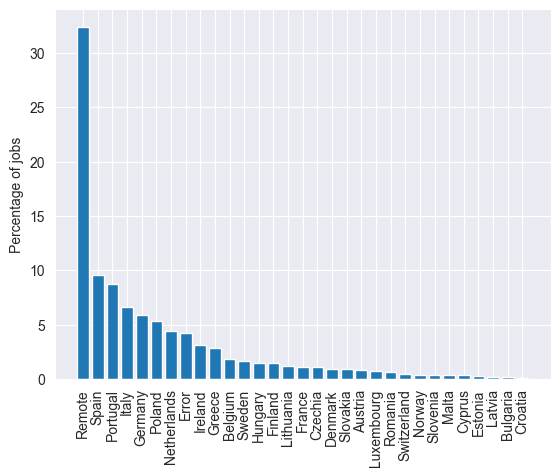

In [177]:
frame=jobs_en['country'].value_counts()
frame=pd.concat([frame,frame/len(jobs_en)*100 ],axis=1)
frame.columns=['count','percentage']
print('total amount of job posts in english: ',len(jobs_en))
sns.set_style("darkgrid")
plt.bar(frame.index, frame['count']/len(jobs_en)*100);
plt.xticks(rotation=90);
plt.ylabel('Percentage of jobs');

# Post time and reposting of job posts written in english

In [180]:
jobs_en['Reposted'].value_counts()/len(jobs_en)*100

Reposted
False    70.075567
True     29.924433
Name: count, dtype: float64

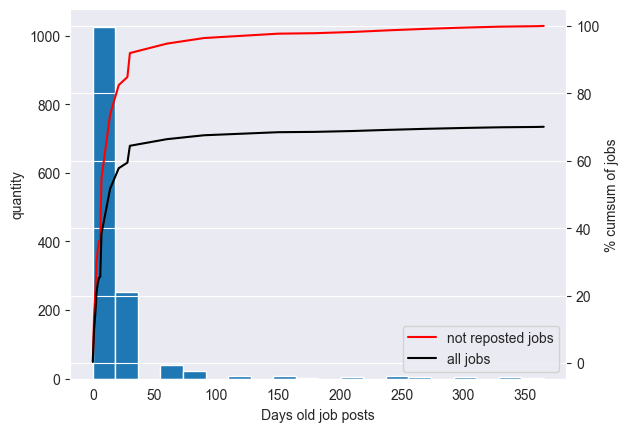

In [181]:
sns.set_style("dark")
c=jobs['lang'].apply(lambda x: is_en(x))
jobs_en=jobs.loc[c]
jobs_en_not_rep=jobs_en[jobs_en['Reposted']==False]

days=pd.to_datetime(jobs_en_not_rep['post time']) - datetime.strptime('2024-03-09', '%Y-%m-%d')
days=abs(days.dt.days)
plt.hist(days,bins=20)
plt.xlabel('Days old job posts')
plt.ylabel('quantity')
plt.twinx()
plt.plot(days.value_counts().sort_index().cumsum()/len(jobs_en_not_rep)*100,color='red',label='not reposted jobs');
plt.plot(days.value_counts().sort_index().cumsum()/len(jobs_en)*100,color='black',label='all jobs');
plt.legend()
plt.ylabel('% cumsum of jobs');
plt.grid(True);

Need to get rid of noise

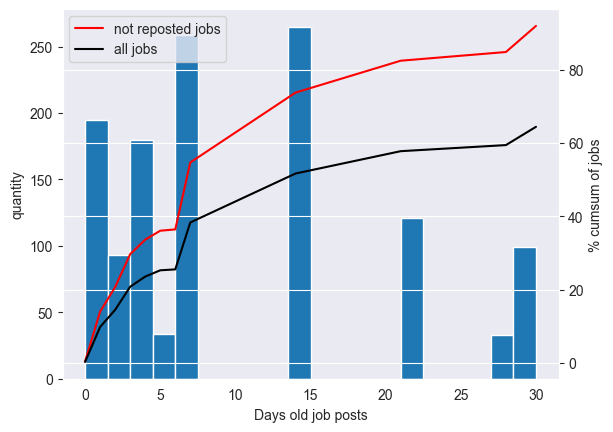

In [182]:
sns.set_style("dark")
c=jobs['lang'].apply(lambda x: is_en(x))
jobs_en=jobs.loc[c]
jobs_en_not_rep=jobs_en[jobs_en['Reposted']==False]

days=pd.to_datetime(jobs_en_not_rep['post time']) - datetime.strptime('2024-03-09', '%Y-%m-%d')
days=abs(days.dt.days)
days=days[days<60]
plt.hist(days,bins=20)
plt.xlabel('Days old job posts')
plt.ylabel('quantity')
plt.twinx()
plt.plot(days.value_counts().sort_index().cumsum()/len(jobs_en_not_rep)*100,color='red',label='not reposted jobs');
plt.plot(days.value_counts().sort_index().cumsum()/len(jobs_en)*100,color='black',label='all jobs');
plt.legend()
plt.ylabel('% cumsum of jobs');
plt.grid(True);

When a job is reposted it is impossible to know when it was posted originally therefore such postings were taken out before making the plots above. Given that reposted jobs should roughly be at least 2 weeks old we can say with decent certainty that around 50% of job postings are no older than 2 weeks. This likely indicates that jobs get filled relatively quickly and a fair bit of data science jobs are constantly created. It could also mean that the data was gathered at unusual time during which a lot of jobs were created though this is less likely.
# Comparing remote, hybrid and on site jobs in english language

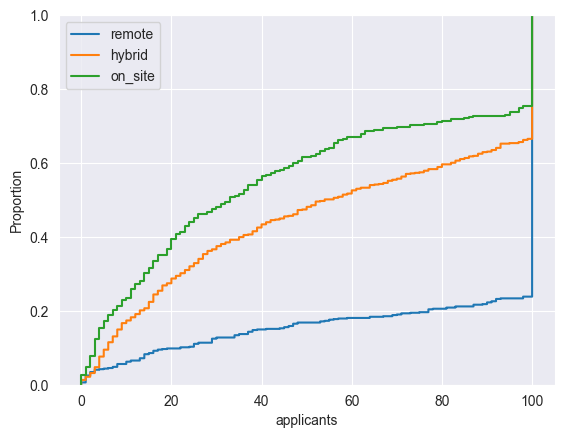

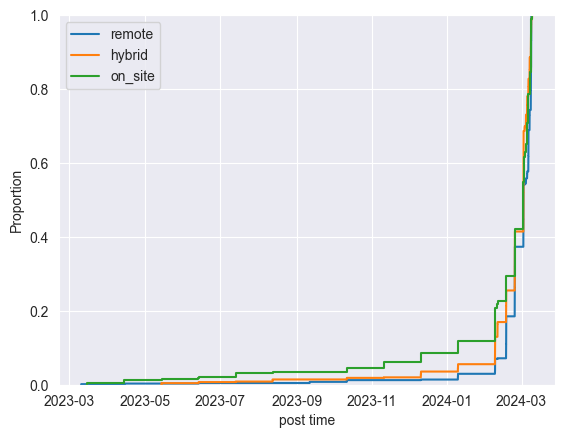

In [183]:
c=jobs['lang'].apply(lambda x: is_en(x))
jobs_en=jobs.loc[c]

c=jobs_en['applicants'].astype(float)
c= c[jobs_en['on_site']==-1]
sns.set_style("darkgrid")
sns.ecdfplot(c,label='remote')
#plt.hist(c,label='remote',bins=11, histtype='step',density=True)

c=jobs_en['applicants'].astype(float)
c= c[jobs_en['on_site']==0]
sns.ecdfplot(c,label='hybrid')
#plt.hist(c,label='hybrid',bins=11, histtype='step',density=True)

c=jobs_en['applicants'].astype(float)
c= c[jobs_en['on_site']==1]
sns.ecdfplot(c,label='on_site')
#plt.hist(c,label='on_site',bins=11, histtype='step',density=True)
plt.legend()
plt.show()

c=jobs['lang'].apply(lambda x: is_en(x))
jobs_en=jobs.loc[c]
jobs_en_not_rep=jobs_en[jobs_en['Reposted']==False]

c=jobs_en['post time']
c= c[jobs_en['on_site']==-1]
sns.ecdfplot(c,label='remote')

c=jobs_en['post time']
c= c[jobs_en['on_site']==0]
sns.ecdfplot(c,label='hybrid')

c=jobs_en['post time']
c= c[jobs_en['on_site']==1]
sns.ecdfplot(c,label='on_site')
plt.legend()
plt.show()

Remote jobs have by far the most applicants while on_site ones have the least though the difference from hybrid positions is not massive. Given the same order of lines in the second plot as in the first one we can conclude that hybrid and remote jobs get filled faster. This means that applying within first or second week after the job has been posted, esspecially the ones that get a lot of applicants such as remote jobs, is important for landing a job.
# A look at junior and senior roles
A fair amount of job posts do not explicitly mention whether a role is junior or senior therefore grouping jobs based on the title is a little naive. Nonetheless, if enough jobs will be captured, such as is the case with senior jobs, we might still get a meaningful snapshot of the situation.

amount of jobs with junior title:  22  or  1.11 % of total jobs


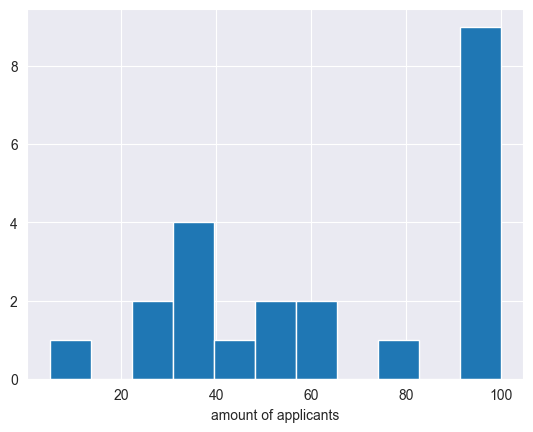

In [184]:
c=jobs['lang'].apply(lambda x: is_en(x))
jobs_en=jobs.loc[c]
def junior(x):
    return ('jr' in x.lower() or 'junior' in x.lower())
c=jobs_en[jobs_en['title'].apply(lambda x: junior(x))]
print('amount of jobs with junior title: ', len(c),' or ', round(len(c)/len(jobs_en)*100,2),'% of total jobs')

plt.hist(c['applicants'],bins=11);
plt.xlabel('amount of applicants');

Not enough jobs to get a meaningful understanding of junior role situation, esspecially when only 22 jobs were gathered acrosss the whole European zone.

amount of jobs with senior title:  602  or  30.33 % of total jobs


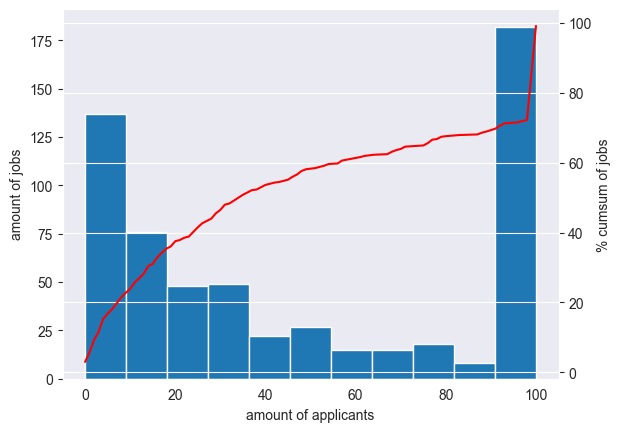

In [185]:
c=jobs['lang'].apply(lambda x: is_en(x))
jobs_en=jobs.loc[c]
len_jobs_en=len(jobs_en)
def senior(x):
    return ('sr' in x.lower() or 'senior' in x.lower())
jobs_en=jobs_en[jobs_en['title'].apply(lambda x: senior(x))]
print('amount of jobs with senior title: ', len(jobs_en),' or ', round(len(jobs_en)/len_jobs_en*100,2),'% of total jobs')

sns.set_style("dark")
plt.hist(jobs_en['applicants'],bins=11);
plt.ylabel('amount of jobs');
plt.xlabel('amount of applicants');
plt.twinx()
plt.plot(jobs_en['applicants'].value_counts().sort_index().cumsum()/len(jobs_en['applicants'])*100,color='red');
plt.grid(True)
plt.ylabel('% cumsum of jobs');

30% of total english written job posts are for senior roles which is a lot. The distribution of applicants is unusual since 40% of jobs have roughly less than 25 applicants and around 30% of jobs have 100 or more applicants. As a result, country (including remote as a seperate option) based analysis ought to be applied

In [186]:
means_country=pd.DataFrame(columns=['mean','quant'],dtype='float')
means_city=pd.DataFrame(columns=['mean','quant'],dtype='float')
for country in jobs_en['country'].unique():
    c=jobs_en['country']==country
    c=jobs_en.loc[c]
    c=c[c['post time']<datetime.now()-timedelta(weeks=1)]
    c=c.dropna()
    c['applicants']=c['applicants'].astype(float)
    means_country.loc[country,'quant']=len(c)
    means_country.loc[country,'mean']=c['applicants'].mean()
    for city in c['city'].unique():
        c_1=c[c['city']==city]
        means_city.loc[city,'quant']=len(c_1)
        means_city.loc[city,'mean']=c_1['applicants'].mean()
means_country=means_country.sort_values(by='mean')
means_country=means_country.dropna()
means_city=means_city.dropna()
means_city=means_city.sort_values(by='mean')
means_city=means_city[means_city['quant']>2]

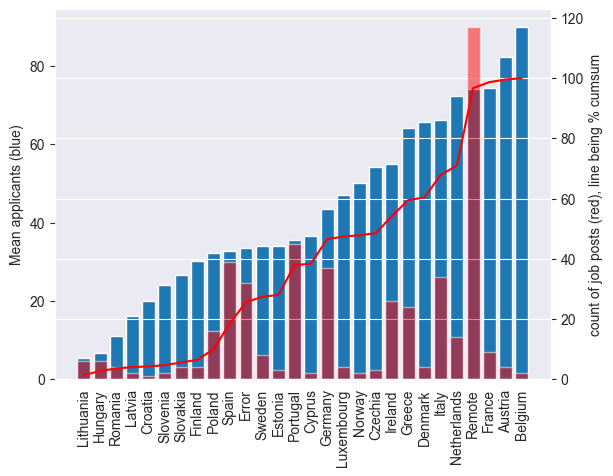

In [187]:
sns.set_style("dark")
plt.bar(means_country.index, means_country['mean']);
plt.xticks(rotation=90);
plt.ylabel('Mean applicants (blue)');
plt.twinx()
plt.grid(True)
plt.bar(means_country.index, means_country['quant'],color='red',alpha=0.5);
plt.plot(means_country.sort_values(by='mean')['quant'].cumsum()/means_country['quant'].sum()*100,color='red')
plt.ylabel('count of job posts (red), line being % cumsum');

Countries and remote job seem to be a good explanation of an unusual distribution since cummulative line behaviour matches that unusual distribution to an extent. To be more precise the barplot indicates that countries such as Lithuania, Poland or Spain does not meet the demand with supply as well  compared to countries such as Italy, Netherlands or France when it comes to senior data scientists. This can be either economic downfall differences or the difference in cummulated talent pool.